# Semantle solving agent - similar cohorts Bayesian approach

Defines an agent that uses Bayesian comparison of multiple cohorts, where each cohort shares a similarity score with the target, to find the semantle target/secret word

In [1]:
from english_words import english_words_set
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import timeit

from semantle_simulator import SemantleSimulator
from similarity_model import SimilarityModel
from cohort_bayes_solver import CohortBayesSolver

## Simulator for semantle

In [2]:
sem_sim = SemantleSimulator()

In [3]:
sem_sim.target = 'ours'

## Agent capabilities

Agent reuses semantle embedding space, but could potentially use a different semantic representation. Word list is closer (~30k) to what a human could potentially recall.

In [4]:
agent_semantics = sem_sim.wv
base_vocabulary = english_words_set
if sem_sim.target not in base_vocabulary:
    base_vocabulary.add(sem_sim.target)
    
similarity = SimilarityModel(agent_semantics, base_vocabulary, precision=0.1, recall=0.5)

## Run the solving agent

The agent makes sensible guesses and updates its belief about likely targets to guide further guesses.

In [5]:
cbs = CohortBayesSolver(similarity, log=True)

In [6]:
%%time
target, steps = cbs.solve(sem_sim)
print(f'target "{similarity.word_string(target)}" (id {target}) reached in {steps} steps')

target "ours" (id 6066) reached in 62 steps
CPU times: user 1.45 s, sys: 218 ms, total: 1.66 s
Wall time: 854 ms


## Visualise the results

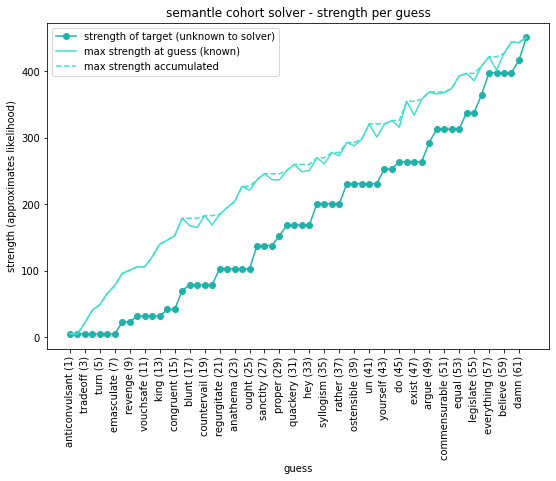

In [7]:
plt.figure(figsize=(9,6))
plt.plot(cbs.logging['target_strength'], '-o', c='lightseagreen')
plt.plot(cbs.logging['max_strength'], c='turquoise')
plt.plot(np.maximum.accumulate(cbs.logging['max_strength']), '--', c='turquoise')
plt.title('semantle cohort solver - strength per guess')
plt.legend(['strength of target (unknown to solver)', 'max strength at guess (known)', 'max strength accumulated'])
plt.ylabel('strength (approximates likelihood)') 
plt.xlabel('guess')
xtick_lim = 30
xtick_step = max(1, steps // xtick_lim)
xticks = range(0, steps, xtick_step)
xtick_labels = [f'{similarity.word_string(cbs.logging["guess"][xt])} ({xt + 1})' for xt in xticks]
plt.xticks(xticks, xtick_labels, rotation=90)
plt.show()

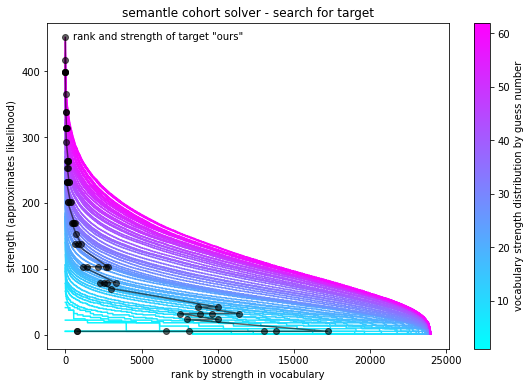

In [8]:
plt.figure(figsize=(9,6))
for i, s in enumerate(cbs.logging['strength']):
    interp = i / len(cbs.logging['strength'])
    plt.plot(list(reversed(sorted(s))), c=mpl.cm.cool(interp))
plt.plot(cbs.logging['target_rank'], cbs.logging['target_strength'], 'o-', c='k', alpha=0.6)
plt.text(500, np.max(cbs.logging['strength']) - 3, f'rank and strength of target "{sem_sim.target}"') 
plt.title('semantle cohort solver - search for target')
plt.ylabel('strength (approximates likelihood)')
plt.xlabel('rank by strength in vocabulary')
guess_norm = mpl.colors.Normalize(vmin=1, vmax=steps)
plt.colorbar(mpl.cm.ScalarMappable(norm=guess_norm, cmap=mpl.cm.cool), label='vocabulary strength distribution by guess number')
plt.show()